<a href="https://colab.research.google.com/github/HumbertoSM-DataScience/TopologyOptimization/blob/main/REDE2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q onnx
!pip install -q tf2onnx

     |████████████████████████████████| 13.1 MB 24.8 MB/s 
     |████████████████████████████████| 440 kB 16.5 MB/s 


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 29 16:56:33 2022

@author: nevej
"""

#Imports
#Importar bibliotecas
import numpy as np
from sklearn.model_selection import train_test_split
#Importar coisas do tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
#Importar minhas classes
from create_folders_with_net_info import create_folders
from Data_generatorH import DataGenerator
#from Unet_Sosnovik_2channels import Net
from Plot_and_predict_during_learning import PlotLearning

from save_pickle import save_pickle
from use_net import use_net_on_data
from save_trained_net import save_trained_net
#from Unet_Sosnovik_2channels import Net
from Unet_Sosnovik_1channel import Net
#from Plot_and_predict_during_learning import PlotLearning
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import trange, tqdm
from sklearn.utils import shuffle


In [ ]:
data_path = "/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_comp_clip5mean_int5.npy"
data = np.load(data_path)
data.reshape(2,10000,40,40,1)
X = data[0]
y = data[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42)


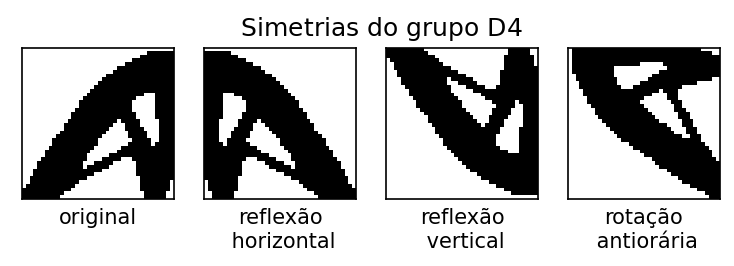

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (6,2), dpi=150)
i=19
ax[0].imshow(y[i],cmap='gray_r')
ax[0].set(xlabel='original')
ax[1].imshow(y[i,:,::-1],cmap='gray_r')
ax[1].set(xlabel='reflexão\n horizontal',title='$\hspace{8}$ Simetrias do grupo D4')
ax[2].imshow(y[i,::-1],cmap='gray_r')
ax[2].set(xlabel='reflexão\n vertical')
ax[3].imshow(np.rot90(y[i]) ,cmap='gray_r')
ax[3].set(xlabel='rotação\n antiorária')
for k in range(4):
  ax[k].set(xticks=[],yticks=[])


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle

def random_d4_transform(x_batch, y_batch):
    '''Apply random transformation from D4 symmetry group
    # Arguments
        x_batch, y_batch: input tensors of size `(batch_size, height, width, any)`
    '''
    batch_size = x_batch.shape[0]
    
    # horizontal flip
    mask = np.random.random(size=batch_size) > 0.5
    x_batch[mask] = x_batch[mask, :, ::-1]
    y_batch[mask] = y_batch[mask, :, ::-1]

    # vertical flip
    mask = np.random.random(size=batch_size) > 0.5
    x_batch[mask] = x_batch[mask, ::-1]
    y_batch[mask] = y_batch[mask, ::-1]
    
    # 90* rotation
    mask = np.random.random(size=batch_size) > 0.5
    x_batch[mask] = np.swapaxes(x_batch[mask], 1, 2)
    y_batch[mask] = np.swapaxes(y_batch[mask], 1, 2)

    return x_batch, y_batch

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,X ,y , batch_size=32,aug=True):
        'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.aug = aug
        self.on_epoch_end()

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(self.X.shape[0]/self.batch_size))

    def __getitem__(self,index):
        self.X_mb = self.X[index*self.batch_size:(index+1)*self.batch_size]
        self.y_mb = self.y[index*self.batch_size:(index+1)*self.batch_size]
        if self.aug:
          self.X_mb ,self.y_mb = random_d4_transform(self.X_mb,self.y_mb)
          return self.X_mb,self.y_mb
        else:
          return self.X_mb,self.y_mb
    def on_epoch_end(self):
      self.X,self.y = shuffle(self.X,self.y)

In [ ]:
class Save_hist:
    def __init__(self, history, path):
        self.history=history
        self.path=path
    def save(self):
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(self.history.history['binary_accuracy'])
        plt.plot(self.history.history['val_binary_accuracy'])
        plt.title('Acurácia binária do modelo')
        plt.ylabel('Acurácia Binária')
        plt.xlabel('Época')
        plt.legend(['Treino', 'Validação'], loc='lower right')
        plt.savefig(self.path +'/plot_binacc.png')
        plt.show()
        plt.clf()
        # summarize history for loss
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Função $\it{loss}$')
        plt.ylabel('$\it{loss}$')
        plt.xlabel('Época')
        plt.legend(['Treino', 'Validação'], loc='upper right')
        plt.savefig(self.path +'/plot_loss.png')
        plt.show()
        

In [ ]:

# Network parameters
#Learning rate
lr=0.001
#Batch size
bs=100
#Number of epochs of training
n_ep=100
#Mass percentage
k=95.25
# Number of convolution filters on the first layers of U-Net
filters_in=16
#Dropout rate
drop_rate=0.1
#Type of network
Net_type='Net_Sosnovik_1channels'
#Name of file to be saved with network info and what is obtained after training the network
# name_files='losscustomizada2'
name_files='teste60'
Aug = True

#Save path to the files with network info and what is obtained after training the network
save_path_general=path='/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas'

# Create folders to save the data of the neural network that will be trained
# Also saves information about the network, such as learning rate and batch size
data_path = f"/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_comp_clip5mean_int5.npy"
data = np.load(data_path)
data.reshape(2,10000,40,40,1)
X = data[0]
y = data[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42)

c=create_folders(save_path_general, lr, bs, n_ep, k, filters_in, drop_rate, name_files, Net_type)
c.create_dirs()

Train_gen = DataGenerator(X_train, y_train,batch_size=bs,aug=Aug)


# Build the neural network
net=Net(filters_in, drop_rate)
model=net.build()
model.summary()

#Compile the network
model.compile(optimizer=Adam(learning_rate=lr,epsilon=1e-5),  loss='binary_crossentropy', metrics=[BinaryAccuracy()])

# Get paths of directories that were created with create_folder in the beggining of the program
model_dir, train_history_dir, bin_e_IoUs_dir, graphs_dir, info_rede_dir, savesnets_dir=c.get_directories()

#Path to the checkpoints that will be saved during training
checkpoint_path = model_dir+"/Checkpoints/.ckpt"
#model.load_weights(checkpoint_path)
# Create a callback that saves the model's weights

# Model checkpoint callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor='val_binary_accuracy',save_best_only=True,save_weights_only=True,
                                                  verbose=0)
# Early stopping callback
earlystop=EarlyStopping(monitor='val_loss', patience=10,verbose=0,mode='min',restore_best_weights=True)

#Callbacks that will be used are placed in callbacks_list
callbacks_list = [cp_callback]#,PlotLearning(X_test,y_test)]

# Fit the model to the data
history=model.fit(Train_gen,
          epochs=n_ep,
          verbose=1,callbacks=callbacks_list,validation_data=(X_test,y_test))

#loss,acc = model.evaluate(X_val,  Y_val, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))
#Load weights from checkpoint_path. They are the weights that led to the best validation binary accuracy during training
model.load_weights(checkpoint_path)


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tensor (InputLayer)      [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 40, 40, 16)   160         ['input_tensor[0][0]']           
                                                                                                  
 conv2d_79 (Conv2D)             (None, 40, 40, 16)   2320        ['conv2d_78[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 20, 20, 16)  0           ['conv2d_79[0][0]']              
 )                                                                                          

In [ ]:
# Save the neural network in formats .h5, pbmodel and .onnx
save_net=save_trained_net(savesnets_dir, model)
save_net.save()

# Use trained network on data to predict outputs,
# The 50 % bigger outputs are set to one and the rest to zero
# Calculate the mean IoU and mean binary accuracy on the data and save it in the correcy directory

usenet=use_net_on_data(model, X_test,y_test,bin_e_IoUs_dir)
mean_Iou,mean_bin_acc=usenet.calculate_IoU_and_binacc()
usenet.save_bin_e_IoU()


# Save plots of the training history
save=Save_hist(history, graphs_dir)
save.save()

# Save training history as lists with pickle
save_pkl=save_pickle(history,train_history_dir)
save_pkl.save()

print(mean_Iou,mean_bin_acc)

with open("/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas/"+"resultados.txt", "a") as myfile:
  myfile.write(f"\n data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, arquivo: {data_path} , \
  teste: {name_files} ,IOU: {mean_Iou}, ACC: {mean_bin_acc} ,DadosTrain: {X_train.shape[0]},  Aug: {Aug},  lr: {lr} , bs = {bs} , n_ep = {n_ep} , n_filtros = {filters_in}")

In [ ]:
model.load_weights("/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas/treino_5_comp_int5/Checkpoints/.ckpt")

In [ ]:

preds = model.predict(X).reshape(10000,40,40)
preds_filtro=np.zeros((10000,40,40))
preds_filtro = np.where(preds > np.median(preds),1,0)

In [ ]:
preds_filtro

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 0, ..., 

In [ ]:
import sys
x = np.sum(np.square(preds_filtro - y_test), axis=(1,2))
y = np.argsort(x)
np.set_printoptions(threshold=sys.maxsize)


In [ ]:
y

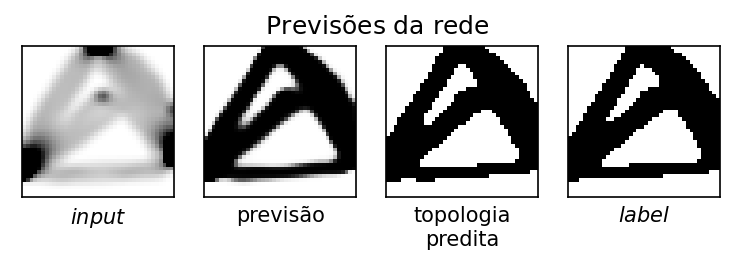

In [ ]:
# Plota algumas previsões da rede
fig, ax = plt.subplots(1,4, figsize = (6,2), dpi=150)
i= 1000
# for i in [1050,  586, 1604,  854,  739,  297, 1551, 1778, 1517, 1361, 1320,
#        1909, 1895, 1120,  331,  482,   63,   56, 1893, 1918,  694,  657,
#        1193,  473,  471,  172,  598,  844, 1716, 1593, 1876, 1788,  993,
#        1610,  380,  361,  567, 1654,   66, 1872, 1493, 1720, 1513,  905,
#        1898, 1596,  931, 1759,  723, 1631,  221,   35,  425,  891,  504,
#         151,  462, 1833, 1406,  756,  742, 1068,  860,  384, 1168,  465,
#          22,   32, 1019,  722, 1722,  638, 1515, 1054, 1905, 1201, 1064,
#        1569, 1697, 1445, 1812, 1323,  194, 1585,  516,  470, 1531, 1138,
#        1349,  983, 1373, 1438, 1043,  614,  878,  160, 1078,  962, 1036,
#         170, 1772,  923,  726,  732, 1556,  969,  552, 1365,  252,  973,
#        1941, 1557, 1755, 1196,  444, 1622, 1901,   55, 1971, 1852,  413,
#         661, 1472,  299, 1928,  599,  378, 1822, 1087, 1095,  229,  212]:
ax[0].imshow(X_test[i],cmap='gray_r')
ax[0].set(xlabel='$\it{input}$')
ax[1].imshow(preds[i],cmap='gray_r')
ax[1].set(xlabel='previsão',title='$\hspace{8}$Previsões da rede')
ax[2].imshow(preds_filtro[i] ,cmap='gray_r')
ax[2].set(xlabel='topologia\npredita')
ax[3].imshow(y_test[i].reshape(40,40),cmap='gray_r')
ax[3].set(xlabel='$\it{label}$')
for k in range(4):
  ax[k].set(xticks=[],yticks=[])
#fig.savefig(f"/content/fig/fig_{i}")
fig.show()

In [ ]:
 # PARA REDES DE UM CANAL
 # MUDAR PACOTE SOSNOVIK p 1 CANAL
 
data_path = f"/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_gradcomp_clip5mean_int{k}.npy"
data = np.load(data_path)
data.reshape(2,10000,40,40,1)
X = data[0]
y = data[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42)

  # REDES DE DOIS CANAIS

X = np.zeros((10000,40,40,2))
data_path1 = "/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_comp_clip5mean_int5.npy"
data1 = np.load(data_path1)
data1 =data1.reshape(2,10000,40,40,1)
X = data1[0]
data_path2 = "/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_gradcomp_clip5mean_int5.npy"
data2 = np.load(data_path2)
data2 = data2.reshape(2,10000,40,40,1)
X = np.concatenate((X,data2[0]),axis=3)
y = data1[1]
X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, random_state=42)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/100
100/100 [==============================] - 18s 43ms/step - loss: 0.3528 - binary_accuracy: 0.8293 - val_loss: 0.2572 - val_binary_accuracy: 0.8847
Epoch 2/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2471 - binary_accuracy: 0.8886 - val_loss: 0.2387 - val_binary_accuracy: 0.8919
Epoch 3/100
100/100 [==============================] - 4s 37ms/step - loss: 0.2361 - binary_accuracy: 0.8932 - val_loss: 0.2324 - val_binary_accuracy: 0.8948
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2315 - binary_accuracy: 0.8953 - val_loss: 0.2317 - val_binary_accuracy: 0.8947
Epoch 5/100
100/100 [==============================] - 4s 37ms/step - loss: 0.2265 - binary_accuracy: 0.8975 - val_loss: 0.2225 - val_binary_accuracy: 0.8993
Epoch 6/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2214 - binary_accuracy: 0.8998 - val_loss: 0.2201 - val_binary_accuracy: 0.9002
Epoch 7/100
100/100 [==============================

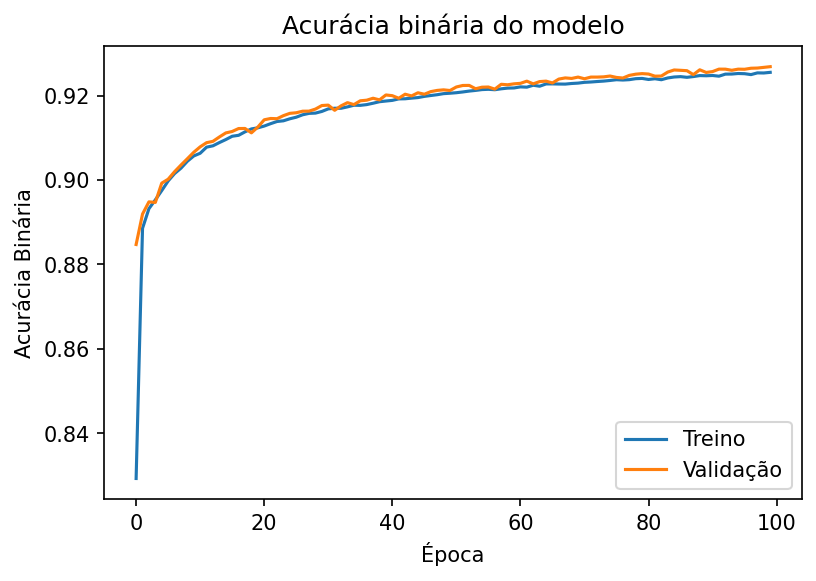

<Figure size 432x288 with 0 Axes>

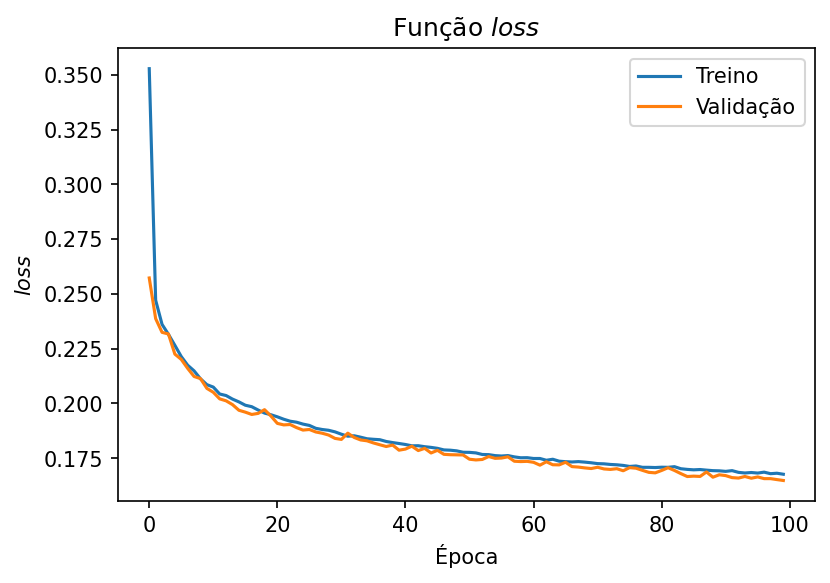

0 0.8644837 0.927317
Epoch 1/100
100/100 [==============================] - 5s 43ms/step - loss: 0.3503 - binary_accuracy: 0.8402 - val_loss: 0.2598 - val_binary_accuracy: 0.8850
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2512 - binary_accuracy: 0.8878 - val_loss: 0.2411 - val_binary_accuracy: 0.8916
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2401 - binary_accuracy: 0.8917 - val_loss: 0.2364 - val_binary_accuracy: 0.8929
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2328 - binary_accuracy: 0.8948 - val_loss: 0.2288 - val_binary_accuracy: 0.8963
Epoch 5/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2289 - binary_accuracy: 0.8963 - val_loss: 0.2248 - val_binary_accuracy: 0.8977
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2244 - binary_accuracy: 0.8982 - val_loss: 0.2221 - val_binary_accuracy: 0.8990
Epoch 7/100
100/100 [==========

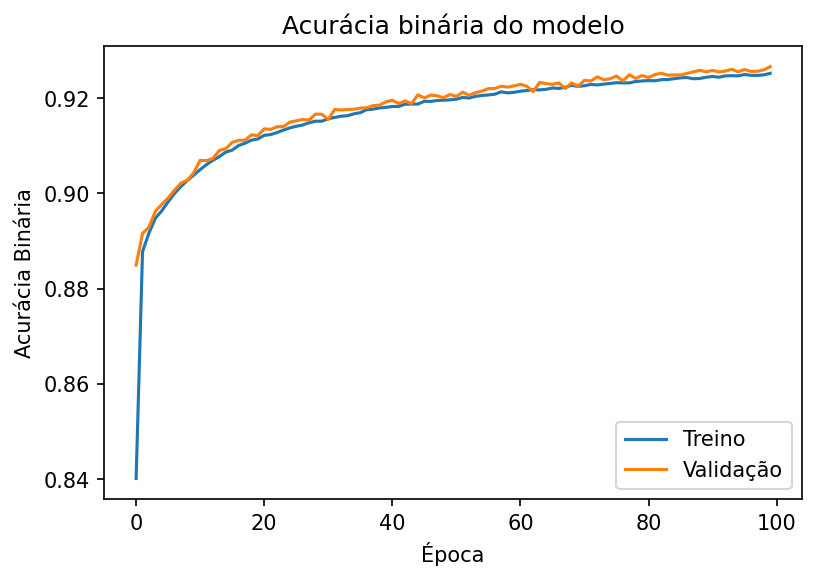

<Figure size 432x288 with 0 Axes>

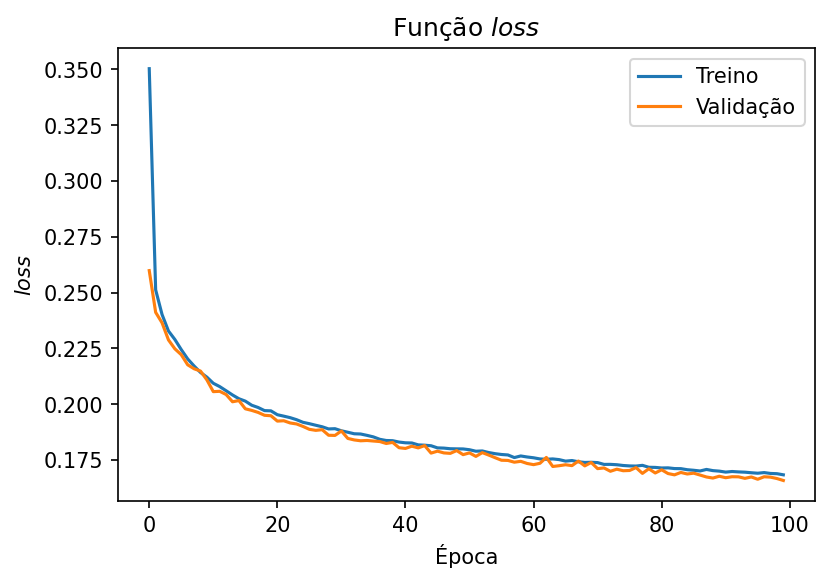

2 0.86381835 0.9269341
Epoch 1/100
100/100 [==============================] - 5s 43ms/step - loss: 0.3283 - binary_accuracy: 0.8432 - val_loss: 0.2545 - val_binary_accuracy: 0.8865
Epoch 2/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2471 - binary_accuracy: 0.8891 - val_loss: 0.2415 - val_binary_accuracy: 0.8909
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2376 - binary_accuracy: 0.8927 - val_loss: 0.2411 - val_binary_accuracy: 0.8914
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2311 - binary_accuracy: 0.8954 - val_loss: 0.2297 - val_binary_accuracy: 0.8957
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2261 - binary_accuracy: 0.8975 - val_loss: 0.2223 - val_binary_accuracy: 0.8990
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2212 - binary_accuracy: 0.8996 - val_loss: 0.2186 - val_binary_accuracy: 0.9003
Epoch 7/100
100/100 [========

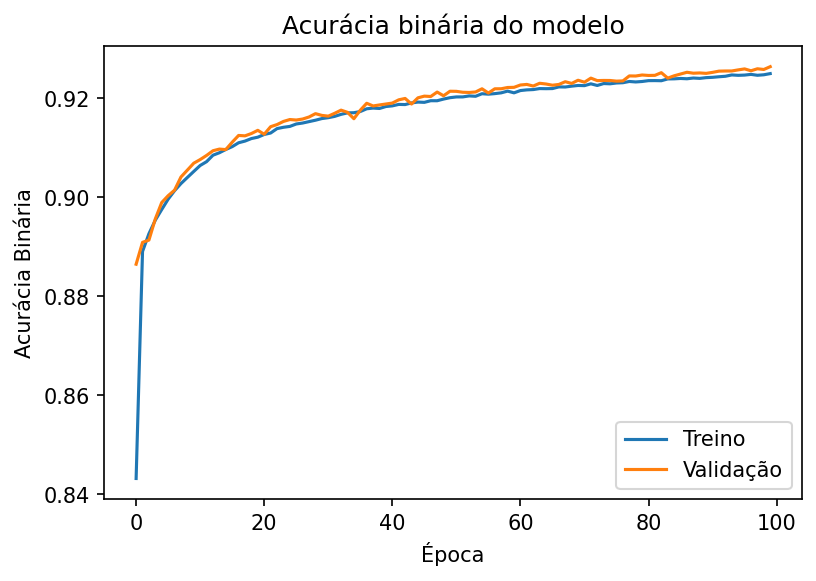

<Figure size 432x288 with 0 Axes>

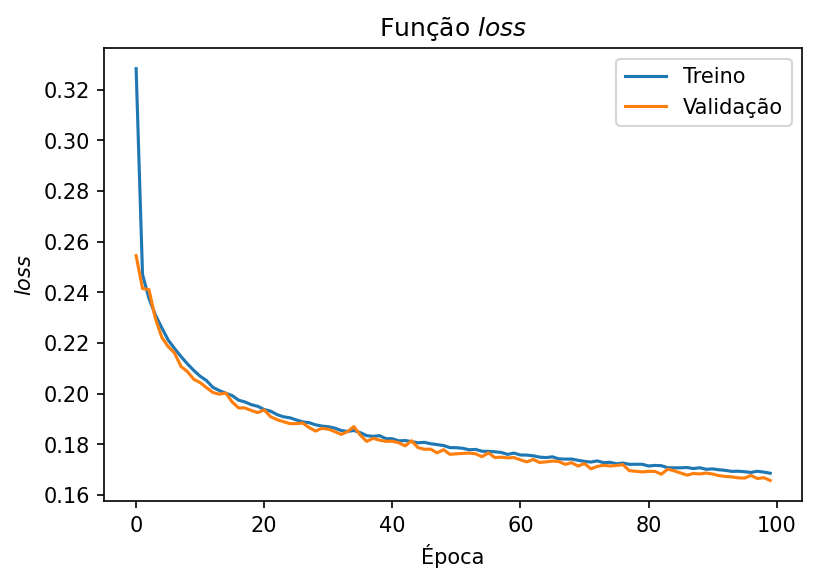

5 0.8635337 0.9267701
Epoch 1/100
100/100 [==============================] - 6s 46ms/step - loss: 0.3400 - binary_accuracy: 0.8468 - val_loss: 0.2546 - val_binary_accuracy: 0.8869
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2454 - binary_accuracy: 0.8900 - val_loss: 0.2357 - val_binary_accuracy: 0.8935
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2333 - binary_accuracy: 0.8944 - val_loss: 0.2311 - val_binary_accuracy: 0.8952
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2283 - binary_accuracy: 0.8966 - val_loss: 0.2283 - val_binary_accuracy: 0.8966
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2247 - binary_accuracy: 0.8983 - val_loss: 0.2201 - val_binary_accuracy: 0.8998
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2193 - binary_accuracy: 0.9006 - val_loss: 0.2147 - val_binary_accuracy: 0.9026
Epoch 7/100
100/100 [=========

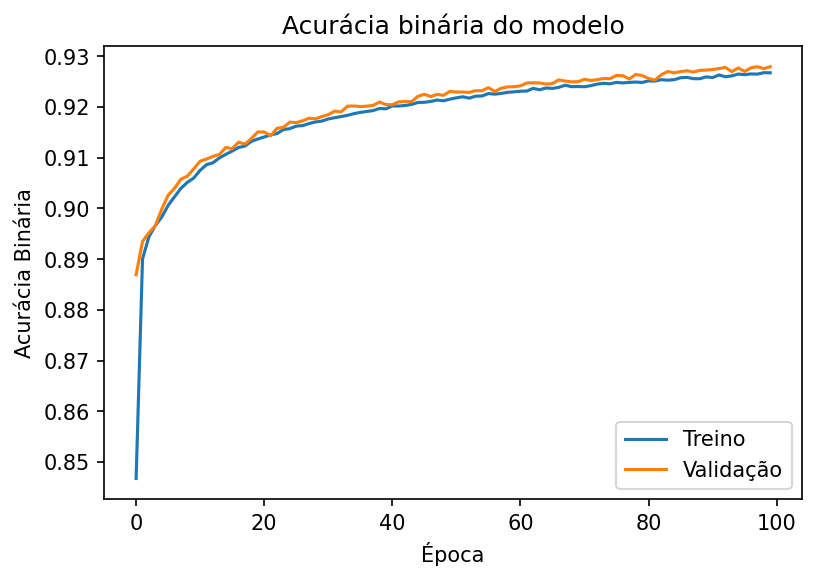

<Figure size 432x288 with 0 Axes>

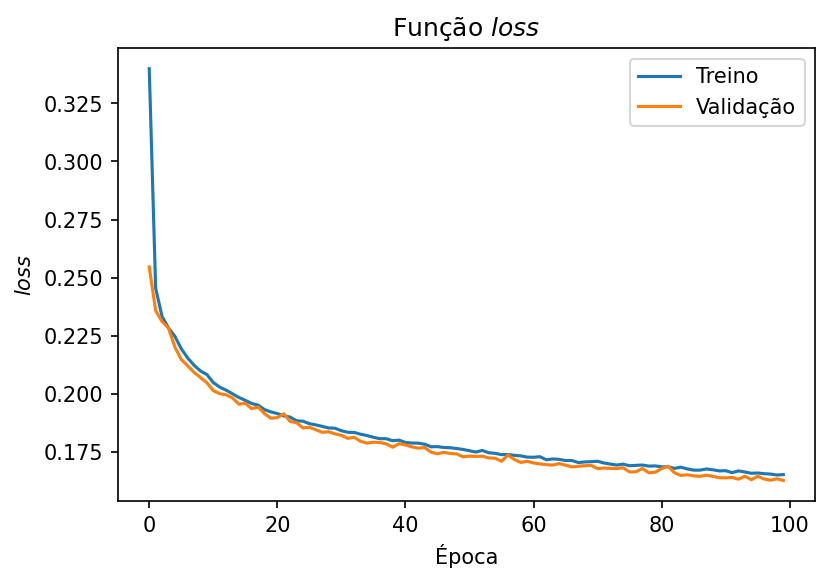

10 0.86618227 0.92829335
Epoch 1/100
100/100 [==============================] - 5s 44ms/step - loss: 0.3478 - binary_accuracy: 0.8469 - val_loss: 0.2425 - val_binary_accuracy: 0.8929
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.2319 - binary_accuracy: 0.8970 - val_loss: 0.2247 - val_binary_accuracy: 0.8990
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.2207 - binary_accuracy: 0.9011 - val_loss: 0.2153 - val_binary_accuracy: 0.9035
Epoch 4/100
100/100 [==============================] - 4s 42ms/step - loss: 0.2150 - binary_accuracy: 0.9036 - val_loss: 0.2139 - val_binary_accuracy: 0.9042
Epoch 5/100
100/100 [==============================] - 4s 43ms/step - loss: 0.2113 - binary_accuracy: 0.9051 - val_loss: 0.2094 - val_binary_accuracy: 0.9063
Epoch 6/100
100/100 [==============================] - 4s 39ms/step - loss: 0.2072 - binary_accuracy: 0.9069 - val_loss: 0.2034 - val_binary_accuracy: 0.9087
Epoch 7/100
100/100 [======

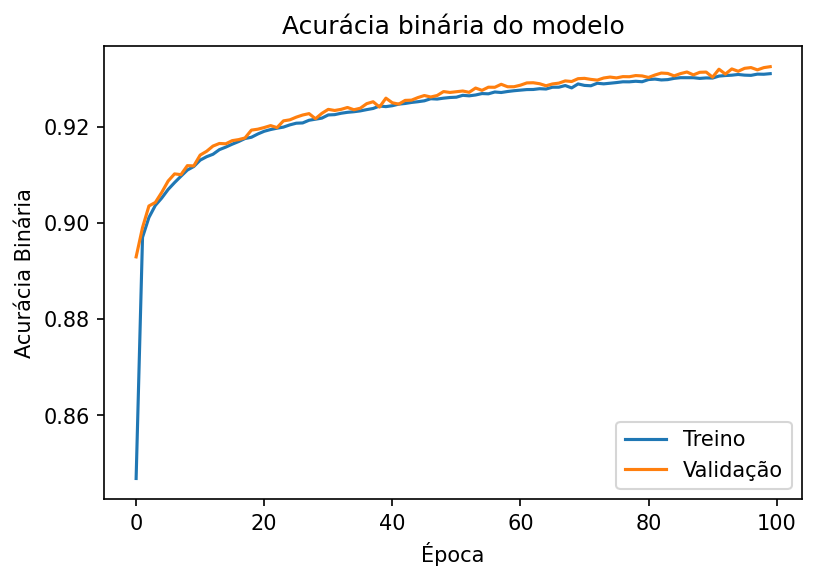

<Figure size 432x288 with 0 Axes>

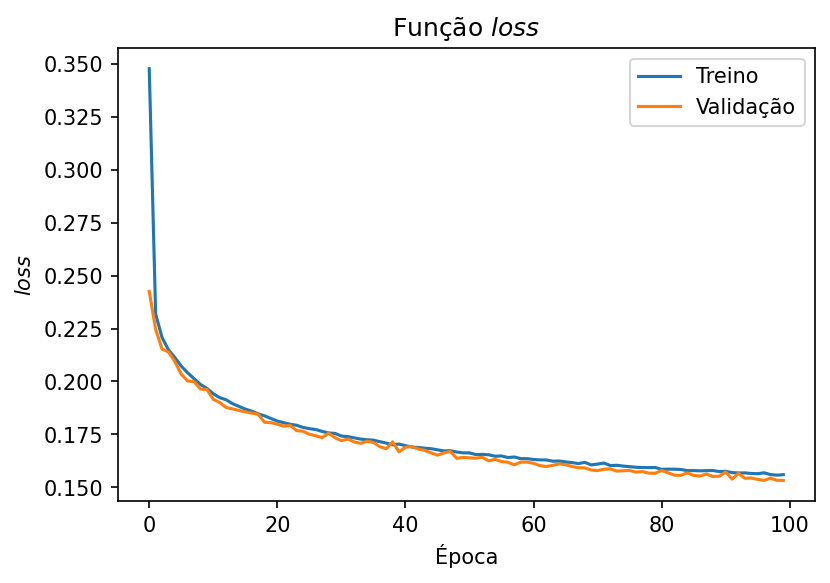

22 0.8743161 0.93294424
Epoch 1/100
100/100 [==============================] - 5s 45ms/step - loss: 0.3046 - binary_accuracy: 0.8679 - val_loss: 0.2049 - val_binary_accuracy: 0.9106
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1966 - binary_accuracy: 0.9140 - val_loss: 0.1939 - val_binary_accuracy: 0.9153
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1883 - binary_accuracy: 0.9175 - val_loss: 0.1838 - val_binary_accuracy: 0.9194
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1843 - binary_accuracy: 0.9193 - val_loss: 0.1817 - val_binary_accuracy: 0.9204
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1819 - binary_accuracy: 0.9204 - val_loss: 0.1794 - val_binary_accuracy: 0.9212
Epoch 6/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1789 - binary_accuracy: 0.9216 - val_loss: 0.1777 - val_binary_accuracy: 0.9222
Epoch 7/100
100/100 [=======

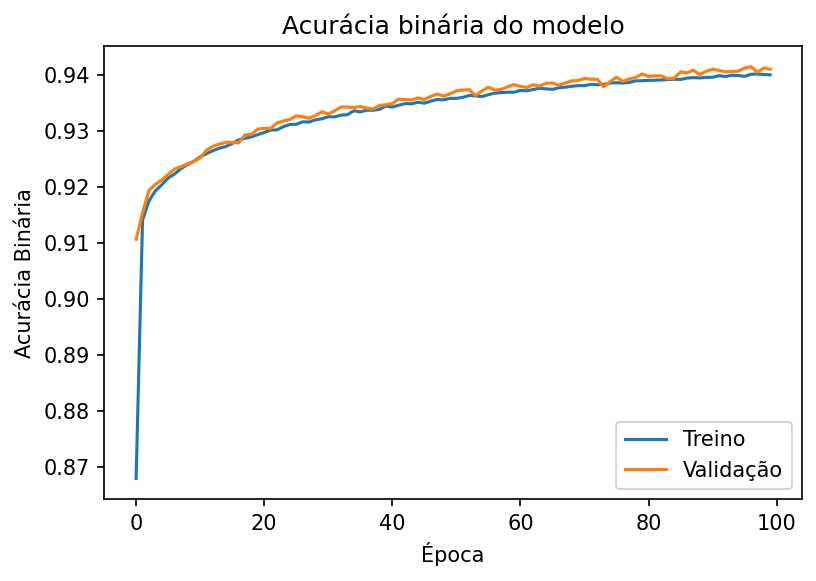

<Figure size 432x288 with 0 Axes>

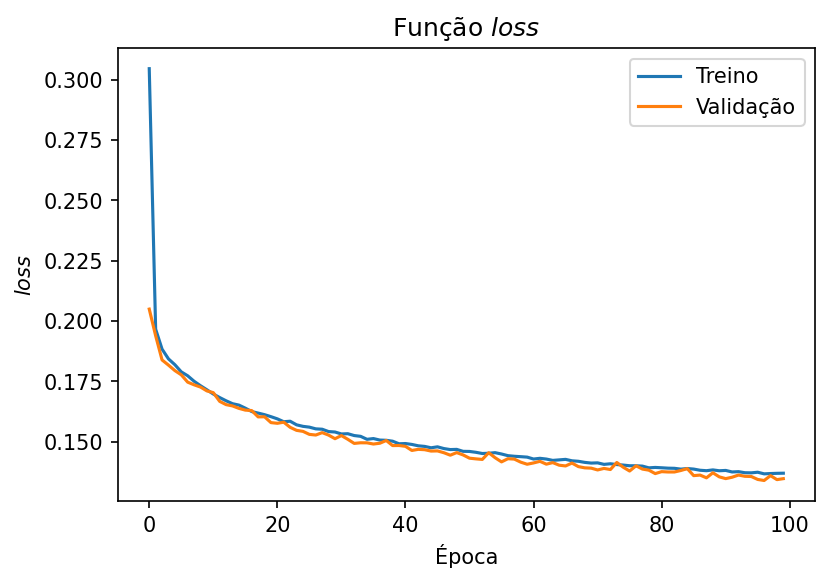

35 0.890084 0.941846
Epoch 1/100
100/100 [==============================] - 5s 43ms/step - loss: 0.2700 - binary_accuracy: 0.8704 - val_loss: 0.1465 - val_binary_accuracy: 0.9399
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - loss: 0.1424 - binary_accuracy: 0.9414 - val_loss: 0.1395 - val_binary_accuracy: 0.9427
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1371 - binary_accuracy: 0.9435 - val_loss: 0.1340 - val_binary_accuracy: 0.9448
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - loss: 0.1340 - binary_accuracy: 0.9447 - val_loss: 0.1322 - val_binary_accuracy: 0.9454
Epoch 5/100
100/100 [==============================] - 4s 39ms/step - loss: 0.1319 - binary_accuracy: 0.9455 - val_loss: 0.1302 - val_binary_accuracy: 0.9461
Epoch 6/100
100/100 [==============================] - 4s 40ms/step - loss: 0.1308 - binary_accuracy: 0.9458 - val_loss: 0.1291 - val_binary_accuracy: 0.9465
Epoch 7/100
100/100 [==========

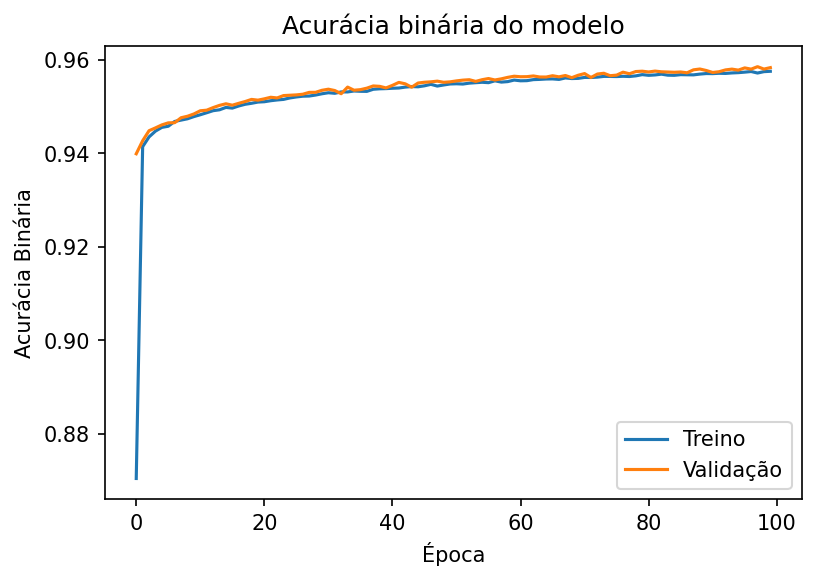

<Figure size 432x288 with 0 Axes>

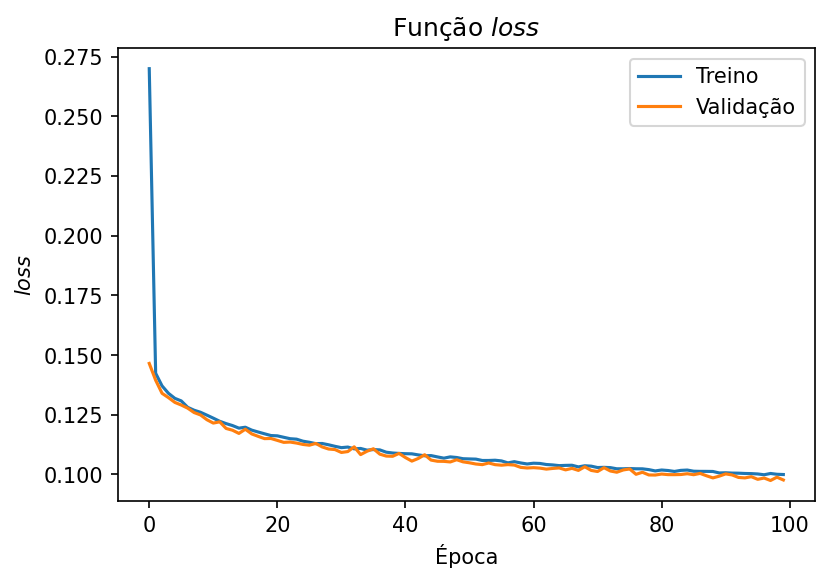

51 0.92106074 0.9589085


In [ ]:
metricas = []
for k in tqdm((0,2,5,10,22,35,51)):
  # Network parameters
  #Learning rate
  lr=0.001
  #Batch size
  bs=100
  #Number of epochs of training
  n_ep=100
  # Number of convolution filters on the first layers of U-Net
  filters_in=16
  #Dropout rate
  drop_rate=0.1
  #Type of network
  Net_type='Net_Sosnovik_1channel'
  #Name of file to be saved with network info and what is obtained after training the network
  # name_files='losscustomizada2'
  name_files=f'treino_11_semval_int{k}'

  Aug = True

  #Save path to the files with network info and what is obtained after training the network
  save_path_general=path='/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas'

  # Create folders to save the data of the neural network that will be trained
  # Also saves information about the network, such as learning rate and batch size
  data_path = f"/content/drive/MyDrive/Redes Neurais - FIS 493/DadosTestes/dados_comp_clip5mean_int{k}.npy"
  data = np.load(data_path)
  data.reshape(2,10000,40,40,1)
  X = data[0]
  y = data[1]
  X_train = X
  X_test = X
  y_train = y
  y_test = y

  c=create_folders(save_path_general, lr, bs, n_ep, k, filters_in, drop_rate, name_files, Net_type)
  c.create_dirs()
  Train_gen = DataGenerator(X_train, y_train,batch_size=bs,aug=Aug)


  # Build the neural network
  net=Net(filters_in, drop_rate)
  model=net.build()
  #model.summary()

  #Compile the network
  model.compile(optimizer=Adam(learning_rate=lr),  loss='binary_crossentropy', metrics=[BinaryAccuracy()])

  # Get paths of directories that were created with create_folder in the beggining of the program
  model_dir, train_history_dir, bin_e_IoUs_dir, graphs_dir, info_rede_dir, savesnets_dir=c.get_directories()

  #Path to the checkpoints that will be saved during training
  checkpoint_path = model_dir+"/Checkpoints/.ckpt"
  #model.load_weights(checkpoint_path)
  # Create a callback that saves the model's weights

  # Model checkpoint callback
  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor='val_binary_accuracy',save_best_only=True,save_weights_only=True,
                                                    verbose=0)
  # Early stopping callback
  earlystop=EarlyStopping(monitor='val_loss', patience=10,verbose=0,mode='min',restore_best_weights=True)

  #Callbacks that will be used are placed in callbacks_list
  callbacks_list = [cp_callback] #,PlotLearning(X_test,y_test)]

  # Fit the model to the data
  history=model.fit(Train_gen,
            epochs=n_ep,
            verbose=1,callbacks=callbacks_list,validation_data=(X_test,y_test))

  #loss,acc = model.evaluate(X_val,  Y_val, verbose=2)
  #print("Restored model, accuracy: {:5.2f}%".format(100*acc))
  #Load weights from checkpoint_path. They are the weights that led to the best validation binary accuracy during training
  model.load_weights(checkpoint_path)
  # Save the neural network in formats .h5, pbmodel and .onnx
  save_net=save_trained_net(savesnets_dir, model)
  save_net.save()

  # Use trained network on data to predict outputs,
  # The 50 % bigger outputs are set to one and the rest to zero
  # Calculate the mean IoU and mean binary accuracy on the data and save it in the correcy directory

  usenet=use_net_on_data(model, X_test,y_test,bin_e_IoUs_dir)
  mean_Iou,mean_bin_acc=usenet.calculate_IoU_and_binacc()
  usenet.save_bin_e_IoU()


  # Save plots of the training history
  save=Save_hist(history, graphs_dir)
  save.save()

  # Save training history as lists with pickle
  save_pkl=save_pickle(history,train_history_dir)
  save_pkl.save()
  metricas.append((k,mean_Iou,mean_bin_acc))
  print(k,mean_Iou,mean_bin_acc)

  with open("/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas/"+"dados.txt", "a") as myfile:
    myfile.write(f"\n {name_files} , {mean_Iou}, {mean_bin_acc}")

  with open("/content/drive/MyDrive/Redes Neurais - FIS 493/Redes treinadas/"+"resultados.txt", "a") as myfile:
    myfile.write(f"\n data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, arquivo: grad e comp , \
    teste: {name_files} ,IOU: {mean_Iou}, ACC: {mean_bin_acc} ,DadosTrain: {X_train.shape[0]},  Aug: {Aug},  lr: {lr} , bs = {bs} , n_ep = {n_ep} , n_filtros = {filters_in}")